In [5]:
# libraries
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import seaborn as sns
import pandas as pd
import math
from scipy.stats import multivariate_normal as mvn

In [6]:
df = pd.read_csv('data_proj_414.csv',index_col=0)
print(df)

               X          Y  Potter  Weasley  Granger  Trip  Close  Far
1       2.466284   3.582118       1        0        0     1      0    0
2       5.508336   8.295713       1        0        0     1      0    0
3       6.784481  11.851393       1        0        0     1      0    0
4       7.550499  14.411812       1        0        0     1      0    0
5      10.402096  17.218079       1        0        0     1      0    7
...          ...        ...     ...      ...      ...   ...    ...  ...
24090  40.615083  74.485727       0        0        1    49      4   16
24091  41.485127  74.335721       0        0        1    49      1    8
24092  41.275887  76.995216       0        0        1    49      1    2
24093  42.176981  76.159014       0        0        1    49      0    1
24094  40.530502  76.063805       0        0        1    49      1    8

[24094 rows x 8 columns]


Obtain a map[107][107] from the dataframe, use "Close" data first and then make up the untouched grids using "Far" data. 

In [7]:
def estimate_from_far(map_far, map_close, x, y, means, covs, r_factor): 
  #means = (0,0)
  #covs = [[1, 0], [0, 1]]
  acc = 0
  count = 0
  pdf = []
  for i in range(-2*r_factor, 3*r_factor):
    for j in range(-2*r_factor, 3*r_factor): 
      if (i, j) == (0, 0): 
        continue
      if (x+i) < 0 or (x+i) >= 107: 
        continue
      if (y+j) < 0 or (y+j) >= 107: 
        continue
      if (map_far[x+i][y+j] != -1): 
        
        i1 = i
        j1 = j
        if (i > 0): 
          i1 = i-r_factor
        elif (i < 0): 
          i1 = i+r_factor
        if (j > 0): 
          j1 = j-r_factor
        elif (j < 0): 
          j1 = j+r_factor
        temp1 = mvn.cdf((i/r_factor, j/r_factor), mean = means, cov = covs)
        temp2 = mvn.cdf((i1/r_factor, j1/r_factor), mean = means, cov = covs)#near the center
        if(temp2 > temp1): 
          acc = acc + (temp2-temp1) * (map_far[x+i][y+j] - map_close[x+i][y+j])
        else: 
          acc = acc + (temp1-temp2) * (map_far[x+i][y+j] - map_close[x+i][y+j])
        count = count + 1
  if count == 0: 
    val = 0
  else: 
    val = acc/count
  #print("acc, count, val: ", (acc, count, val))
  return(val)

In [8]:
resolution_factor=10
min_resolution_x=[]
min_resolution_y=[]


map_close = np.zeros((107*resolution_factor, 107*resolution_factor))
one_grid_count_close=np.zeros((107*resolution_factor, 107*resolution_factor))
max_one_grid_count_close=0

map_far = np.zeros((107*resolution_factor, 107*resolution_factor))
one_grid_count_far=np.zeros((107*resolution_factor, 107*resolution_factor))
max_one_grid_count_far=0

map_uneven = np.zeros((107*resolution_factor, 107*resolution_factor))
map_modified = np.zeros((107*resolution_factor, 107*resolution_factor))

for i in range(1, len(df['X'])+ 1):
  #if i<len(df['X']):
    #min_resolution_x.append(abs(df['X'][i]- df['X'][i+1])) #min(min_resolution_x,abs(df['X'][i]- df['X'][i+1]))
    #min_resolution_y.append(abs(df['Y'][i]- df['Y'][i+1]))#min(min_resolution_y,abs(df['Y'][i]- df['Y'][i+1]))
  x =int(round(df['X'][i],1 )*resolution_factor)
  y =int(round(df['Y'][i],1 )*resolution_factor)
  #record close
  one_grid_count_close[x][y]+=1
  max_one_grid_count_close=max(max_one_grid_count_close,one_grid_count_close[x][y])
  map_close[x][y] = map_close[x][y] + df['Close'][i]
  #record far
  one_grid_count_far[x][y] +=1
  max_one_grid_count_far=max(max_one_grid_count_far,one_grid_count_far[x][y])
  map_far[x][y] = map_far[x][y] + df['Far'][i]

#calculate close
for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_close[i][j] == 0): 
      map_close[i][j] = -1
    else: 
      map_close[i][j] = map_close[i][j] / one_grid_count_close[i][j]

#calculate far
for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_far[i][j] == 0): 
      map_far[i][j] = -1
    else: 
      map_far[i][j] = map_far[i][j] / one_grid_count_far[i][j]


#obtain the final map with estimation using far data
means = (0,0)
covs = [[1, 0], [0, 1]]

for i in range(107*resolution_factor): 
  for j in range(107*resolution_factor): 
    if (one_grid_count_close[i][j] == 0): 
      map_uneven[i][j] = estimate_from_far(map_far, map_close, i, j, means, covs, resolution_factor)
      if (map_uneven[i][j] != 0): 
        map_modified[i][j] = map_uneven[i][j] # a record of modified data using far data
    else: 
      map_uneven[i][j] = map_close[i][j]
      


F:\Anaconda3\envs\VE414\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


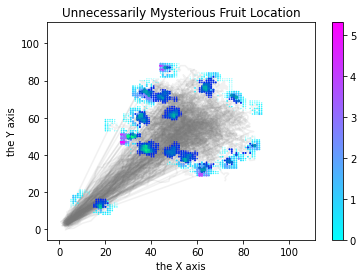

In [9]:
ntrip = 49

cmap = plt.cm.get_cmap('Greys')
for i in range(1, ntrip+1): 
    rs_df = df.loc[df['Trip'] == i]
    c = cmap(30/ntrip)
    plt.plot(rs_df['X'], rs_df['Y'], color = c, alpha = 0.1, zorder = 0)

X = []
Y = []
close = []
modi = []

for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    X.append(i)
    Y.append(j)
    close.append(map_close[i][j])
    modi.append(map_modified[i][j])

plt.scatter(X, Y, s = close, c = close, cmap="winter", alpha=1, linewidth=1, zorder = 10)
plt.scatter(X, Y, s = modi, c = modi, cmap = "cool", alpha = 1, zorder = 5)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()
plt.title("Unnecessarily Mysterious Fruit Location")
plt.show()

In [10]:
def balance_out_map(map, x, y, r_factor): 
  left = 0
  right = 0
  up = 0
  down = 0
  if x > 0 and x < 106*r_factor: 
    if map[x-1][y] + map[x+1][y] != 0: 
      left = (map[x-1][y])/(map[x-1][y] + map[x+1][y])
      right = (map[x+1][y])/(map[x-1][y] + map[x+1][y])
    else: #nothing on the sides
      left = 0
      right = 0
  elif x > 0: # x = 106, rightmost column
    left = 1
    right = 0
  else: # x = 0, leftmost comlumn
    left = 0
    right = 1
  if y > 0 and y < 106*r_factor: 
    if map[x][y-1] + map[x][y+1] != 0: 
      down = (map[x][y-1])/(map[x][y-1] + map[x][y+1])
      up = (map[x][y+1])/(map[x][y-1] + map[x][y+1])
    else: # nothing
      up = 0
      down = 0
  elif y > 0: # y = 106, bottom row
    up = 1
    down = 0
  else: # y = 0, top row
    up = 0
    down = 1
  return({"left": left, "right": right, "up": up, "down": down})

In [11]:
map_proportion = [[{"left":0,"right":0, "up": 0, "down": 0} for y in range(107*resolution_factor)] for x in range(107*resolution_factor)]
for i in range(107*resolution_factor):
  for j in range(107*resolution_factor):
    map_proportion[i][j]= balance_out_map(map_uneven, i, j, resolution_factor)


In [12]:
def calculate_map(map_uneven, map_prop, x, y, r_factor): 
  count = 1
  acc = []
  acc.append(map_uneven[x][y] * map_prop[x][y]['left']*map_prop[x][y]['up'])
  if x > 0: 
    acc.append(map_uneven[x-1][y]*map_prop[x-1][y]['left']*map_prop[x-1][y]['down'])
    count = count + 1
  if y > 0: 
    acc.append(map_uneven[x][y-1]*map_prop[x][y-1]['right']*map_prop[x][y-1]['up'])
    count = count + 1
  if x > 0 and y > 0: 
    acc.append(map_uneven[x-1][y-1]*map_prop[x-1][y-1]['right']*map_prop[x-1][y-1]['down'])
    count = count + 1
  val = max(acc)
  return val
  

In [13]:
map_even = np.zeros((107*resolution_factor, 107*resolution_factor))
count = 0 
for i in range(107*resolution_factor):
  for j in range(107*resolution_factor):
    map_even[i][j] = calculate_map(map_uneven, map_proportion, i, j, resolution_factor)

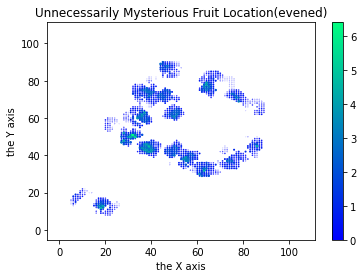

In [14]:
even = []

for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    even.append(map_even[i][j])

plt.scatter(X, Y, s = even, c = even, cmap="winter", alpha=1, linewidth=1, zorder = 10)
# Add titles (main and on axis)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()

plt.title("Unnecessarily Mysterious Fruit Location(evened)")

# Show the graph
plt.show()

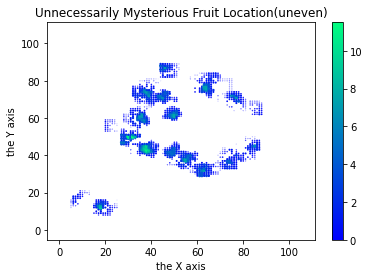

In [15]:
uneven = []
for i in range(0,107*resolution_factor):
  for j in range(0,107*resolution_factor):
    uneven.append(map_uneven[i][j])

plt.scatter(X, Y, s = uneven, c = uneven, cmap="winter", alpha=1, linewidth=1, zorder = 10)
# Add titles (main and on axis)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.colorbar()

plt.title("Unnecessarily Mysterious Fruit Location(uneven)")

# Show the graph
plt.show()

In [16]:
np.histogram(even, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


(array([11101,   210,    94,    34,     8,     1,     1,     0,     0,
            0,     0,     0], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [17]:
np.histogram(uneven, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

(array([10935,   248,   101,    58,    41,    22,    14,    17,     5,
            5,     1,     2], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

Use EM algorithm to find the center of clusters. 

In [18]:
#need to modify the even data so that it can fit the EM algo we used in homework 4
data_em = []
#data_em_np=np.zeros((107*resolution_factor,107*resolution_factor))
for i in range(107*resolution_factor):
  for j in range(107*resolution_factor):
    for k in range(round(map_even[i][j])): 
      data_em.append([i, j])


print(data_em)

[[6, 18], [7, 15], [7, 19], [9, 17], [9, 20], [15, 13], [16, 13], [16, 14], [17, 12], [17, 12], [17, 13], [17, 13], [17, 13], [17, 14], [17, 14], [17, 15], [17, 16], [18, 10], [18, 11], [18, 11], [18, 12], [18, 12], [18, 12], [18, 12], [18, 12], [18, 13], [18, 13], [18, 13], [18, 14], [18, 14], [18, 15], [18, 15], [18, 16], [19, 12], [19, 12], [19, 12], [19, 13], [19, 13], [19, 13], [19, 13], [19, 14], [19, 14], [19, 15], [19, 16], [20, 13], [20, 14], [20, 15], [20, 16], [21, 11], [21, 14], [21, 15], [21, 16], [22, 12], [22, 14], [27, 47], [27, 47], [27, 47], [27, 48], [27, 50], [27, 50], [27, 51], [28, 46], [28, 46], [28, 47], [28, 47], [28, 48], [28, 48], [28, 48], [28, 48], [28, 49], [28, 50], [28, 51], [28, 52], [28, 52], [28, 52], [28, 52], [29, 46], [29, 47], [29, 47], [29, 48], [29, 48], [29, 49], [29, 50], [29, 50], [29, 51], [29, 51], [29, 52], [30, 46], [30, 47], [30, 47], [30, 48], [30, 49], [30, 49], [30, 50], [30, 50], [30, 50], [30, 51], [30, 51], [30, 52], [31, 47], [31,

In [19]:
def compute_membership_weights(data, cluster_weights, means, covariances):
  member_weights = np.zeros((len(data), len(means)))
  for i in range(len(data)):
    for k in range(len(means)):
      member_weights[i, k] = cluster_weights[k]*mvn.pdf(data[i], mean=means[k], cov=covariances[k]) #alpha * P(data | mu, cov)
      #usage: prob = mvn.pdf([0.5, 0.5], mean = [0, 0], cov = [[1, 0], [0, 1]])
  sums = member_weights.sum(axis=1).reshape(-1, 1) #transpose
  member_weights = member_weights/sums
  return member_weights

def compute_cluster_weights(member_weights):
  return np.sum(member_weights, axis=0)/len(member_weights)

def compute_cluster_means(data, member_weights, ncluster):
  soft_counts = np.sum(member_weights, axis=0)
  means = [np.zeros(len(data[0]))] * ncluster
  for k in range(len(soft_counts)):
    weighted_sum = 0.
    for i in range(len(data)):
      weighted_sum += np.array(data[i]) * member_weights[i, k]
      means[k] = weighted_sum/soft_counts[k]
  return means

def compute_cluster_covariances(data, member_weights, means, ncluster):
  soft_counts = np.sum(member_weights, axis=0)
  ndim = len(data[0])
  covariances = [np.zeros((ndim, ndim))] * ncluster
  for k in range(ncluster):
    weighted_sum = np.zeros((ndim, ndim))
    for i in range(len(data)):
      weighted_sum += member_weights[i, k] * np.outer((data[i]-means[k]), (data[i]-means[k]))
    covariances[k] = weighted_sum/soft_counts[k]
  return covariances

def log_sum_exp(Z):
  return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs, ncluster): 
  num_dim = len(data[0])
  ll = 0
  for d in data:
    Z = np.zeros(ncluster)
    for k in range(ncluster):
      delta = np.array(d) - means[k]
      exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
      Z[k] += np.log(weights[k])
      Z[k] -= 1/2. * (num_dim * np.log(2*np.pi)+np.log(np.linalg.det(covs[k]))+exponent_term)
  ll += log_sum_exp(Z)
  return ll

def EM(data, init_means, init_covariances, init_cluster_weights, ncluster, maxiter=100, thresh=1e-4):
  #make copies of parameters
  print(data)
  means = init_means[:]
  covariances = init_covariances[:]
  cluster_weights = init_cluster_weights[:]

  membership_weights = np.zeros((len(data), len(means)))
  ll = loglikelihood(data, cluster_weights, means, covariances, ncluster)
  ll_track = [ll]

  for itr in range(maxiter):
    #print("----iteration time: ", itr, "----")
    #print("means: ", means)
    #print("cov: ", covariances)
    #print("cluster_weights: ", cluster_weights)
    try:
      membership_weights = compute_membership_weights(data, cluster_weights, means, covariances) #checked
    except:
      print("error: compute_membership_weights")
    try:
      cluster_weights = compute_cluster_weights(membership_weights) #checked
    except:
      print("error: compute_cluster_weights")
    try:
      means = compute_cluster_means(data, membership_weights, ncluster)
    except:
      print("error: compute_cluster_means")
    try:
      covariances = compute_cluster_covariances(data, membership_weights, means, ncluster)
    except:
      print("error: compute_cluster_covariances")
    try:
      new_ll = loglikelihood(data, cluster_weights, means, covariances, ncluster)
    except:
      print("error: loglikelihood")
    ll_track.append(new_ll)
    if (new_ll-ll)<thresh and new_ll > np.inf:
      break
    ll = new_ll

  return {"membership_weights":membership_weights, "cluster_weights": cluster_weights, "means": means, "covs": covariances, "lll": ll_track}  

In [20]:
#means = [[19.12354, 15.0213], [7.0126, 20.123], [25.030021, 45.003],[25.01238, 55.0245], [35.0564, 50.00564], [40.213, 40.02346], [40.0456, 60.0789], [40.2137, 75.013873], [45.00120, 60.045687], [45.02376, 40.027829], [45.02786, 85.056678], [50.276, 40.02756], [60.0827, 30.02678], [60.025678, 75.05267], [70.05426, 40.02456], [70.02456, 70.0542678], [90.0452678, 40.04563]]
means = [[19.05426, 15.07627],  [40.04526, 40.04526],  [70.04526, 60.004256]]
covariance = [[[1, 0],[0, 1]], [[1, 0],[0, 1]], [[1, 0],[0, 1]]]
cw = [0.3, 0.3, 0.4]
ncluster = 3
ans = EM(data_em, means, covariance, cw, ncluster)
print("means: ", ans['means'])
print("cov: ", ans['covs'])
print("cluster_weights:", ans['cluster_weights'])

[[6, 18], [7, 15], [7, 19], [9, 17], [9, 20], [15, 13], [16, 13], [16, 14], [17, 12], [17, 12], [17, 13], [17, 13], [17, 13], [17, 14], [17, 14], [17, 15], [17, 16], [18, 10], [18, 11], [18, 11], [18, 12], [18, 12], [18, 12], [18, 12], [18, 12], [18, 13], [18, 13], [18, 13], [18, 14], [18, 14], [18, 15], [18, 15], [18, 16], [19, 12], [19, 12], [19, 12], [19, 13], [19, 13], [19, 13], [19, 13], [19, 14], [19, 14], [19, 15], [19, 16], [20, 13], [20, 14], [20, 15], [20, 16], [21, 11], [21, 14], [21, 15], [21, 16], [22, 12], [22, 14], [27, 47], [27, 47], [27, 47], [27, 48], [27, 50], [27, 50], [27, 51], [28, 46], [28, 46], [28, 47], [28, 47], [28, 48], [28, 48], [28, 48], [28, 48], [28, 49], [28, 50], [28, 51], [28, 52], [28, 52], [28, 52], [28, 52], [29, 46], [29, 47], [29, 47], [29, 48], [29, 48], [29, 49], [29, 50], [29, 50], [29, 51], [29, 51], [29, 52], [30, 46], [30, 47], [30, 47], [30, 48], [30, 49], [30, 49], [30, 50], [30, 50], [30, 50], [30, 51], [30, 51], [30, 52], [31, 47], [31,

F:\Anaconda3\envs\VE414\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
F:\Anaconda3\envs\VE414\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [21]:
print(data_em)

[[6, 18], [7, 15], [7, 19], [9, 17], [9, 20], [15, 13], [16, 13], [16, 14], [17, 12], [17, 12], [17, 13], [17, 13], [17, 13], [17, 14], [17, 14], [17, 15], [17, 16], [18, 10], [18, 11], [18, 11], [18, 12], [18, 12], [18, 12], [18, 12], [18, 12], [18, 13], [18, 13], [18, 13], [18, 14], [18, 14], [18, 15], [18, 15], [18, 16], [19, 12], [19, 12], [19, 12], [19, 13], [19, 13], [19, 13], [19, 13], [19, 14], [19, 14], [19, 15], [19, 16], [20, 13], [20, 14], [20, 15], [20, 16], [21, 11], [21, 14], [21, 15], [21, 16], [22, 12], [22, 14], [27, 47], [27, 47], [27, 47], [27, 48], [27, 50], [27, 50], [27, 51], [28, 46], [28, 46], [28, 47], [28, 47], [28, 48], [28, 48], [28, 48], [28, 48], [28, 49], [28, 50], [28, 51], [28, 52], [28, 52], [28, 52], [28, 52], [29, 46], [29, 47], [29, 47], [29, 48], [29, 48], [29, 49], [29, 50], [29, 50], [29, 51], [29, 51], [29, 52], [30, 46], [30, 47], [30, 47], [30, 48], [30, 49], [30, 49], [30, 50], [30, 50], [30, 50], [30, 51], [30, 51], [30, 52], [31, 47], [31,

In [22]:
np.isnan(data_em).any()

False

In [23]:
np.isinf(data_em).any()

False

converged iteration: 60
converged or not:  True
means
[[55.83625003 38.21149881]
 [35.71059271 60.50281951]
 [64.79651633 77.48095771]
 [17.46296296 13.75925926]
 [39.94271313 42.96744528]
 [85.04239822 44.88208489]
 [46.02564007 87.15385134]
 [30.48878059 49.76440044]
 [45.51114545 71.94576944]
 [77.32620791 71.28245687]
 [37.62233908 73.54529341]
 [37.62067496 44.82597651]
 [62.92612415 32.39382756]
 [49.93308297 62.40587071]
 [49.55279204 42.48674771]
 [74.98917817 36.84203537]]
covariances
[[[ 3.78573022  0.89659041]
  [ 0.89659041  3.77144995]]

 [[ 4.3499272  -0.84476679]
  [-0.84476679  4.6445227 ]]

 [[ 3.02042691  1.66765319]
  [ 1.66765319  7.05981428]]

 [[12.10048111 -3.77743484]
  [-3.77743484  3.88648934]]

 [[ 2.07841529  0.44678299]
  [ 0.44678299  2.0231578 ]]

 [[ 2.9747124   0.36536549]
  [ 0.36536549  1.76249814]]

 [[ 2.28139616 -0.51676085]
  [-0.51676085  3.20707819]]

 [[ 5.07979808  1.81066533]
  [ 1.81066533  3.39029941]]

 [[ 5.10002001  1.12029354]
  [ 1.120

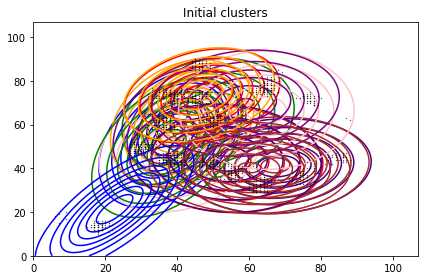

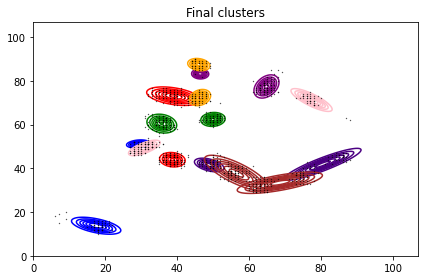

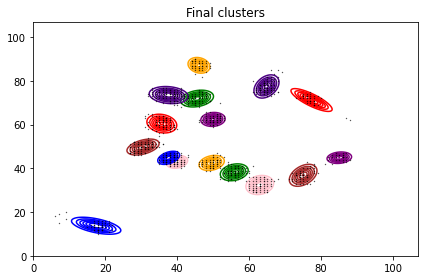

In [24]:
'''
try:
  print(axv)
except:
  print("An exception occurred")
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture


class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)

        # for np.cov, rowvar = False,
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break

            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)

        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]

        return self



def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko',markersize=0.3)

    delta = 0.2 #0.025
    k = means.shape[0]
    x = np.arange(0.0, 107.0, delta)
    y = np.arange(0.0, 107.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo','blue','pink','purple','orange','brown']
    #col=[(255, 255, 0),(1,5,5)]
    
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        if(i==0):
            z_grid_sum = z_grid
        else:
            z_grid_sum +=z_grid
        #print(z_grid)
        cs=plt.contour(x_grid, y_grid, z_grid, colors = col[i%len(col)],extend='both')
        cs.cmap.set_over('red')
        cs.cmap.set_under('blue')
        cs.changed()
    
    #cmaps = colors.LinearSegmentedColormap.from_list('mylist',col,N=3000)
    #plt.contour(x_grid, y_grid, z_grid_sum)
    #plt.contourf(x_grid, y_grid, z_grid_sum)#,cmap=cmaps)#, colors = col[i%len(col)])
    plt.title(title)
    plt.tight_layout()

'''
df = pd.read_csv('raw_data.csv',index_col=0)
plt.scatter(df['X'],df['Y'])
plt.xlabel('X');
plt.ylabel('Y');
X=df.to_numpy()
'''
#xx=[df['X'].values.tolist() for x in df.columns]
#yy=[df['Y'].values.tolist() for y in df.columns]
#df.loc['']
'''
X=np.zeros((  len(df['X'])+1 ,2))
for i in range(1, len(df['X'])+ 1):
    X[i][0]=df2[i][0] #alist['X'][i]
    X[i][1]=df2[i][1] #alist['Y'][i] #df['Y'].iloc(i) #int(df.loc[df['Y'] == i])
'''


X=np.array(data_em)

n_clusters=16
gmm = GMM(n_components = n_clusters, n_iters = 1, tol = 1e-4, seed = 4)
gmm.fit(X)

plot_contours(X, gmm.means, gmm.covs, 'Initial clusters')

gmm = GMM(n_components = n_clusters, n_iters = 60, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')


# use library to confirm results
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'full',
                      max_iter =2000, random_state = n_clusters)
gmm.fit(X)

print('converged or not: ', gmm.converged_)
plot_contours(X, gmm.means_, gmm.covariances_, 'Final clusters')
print("means")
print(gmm.means_)
print("covariances")
print(gmm.covariances_)